In [1]:
# SGD Classifier with majority of features still included
# Actually one of the best performing models

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import locale
#import scipy
#from scipy.stats import randint
import random
import csv
import joblib

In [2]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [3]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


survival 	Survival 	0 = No, 1 = Yes

pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd

sex 	Sex 	

Age 	Age in years 	

sibsp 	# of siblings / spouses aboard the Titanic 	

parch 	# of parents / children aboard the Titanic 	

ticket 	Ticket number 	

fare 	Passenger fare 	

cabin 	Cabin number 	

embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#because there's so many null values in cabin, I'm going to leave it out on this first try
#also gonna delete the two passengers without embarked data, since why bother and it's only two out of 891
train_set.dropna(subset=["Embarked"], inplace=True)
nec_data = train_set.copy()

nec_data = nec_data.drop("Survived", axis=1)
survived = pd.DataFrame(train_set["Survived"].copy())
nec_data = nec_data.drop("PassengerId", axis=1)

nec_data = nec_data.drop("Name", axis=1)
nec_data = nec_data.drop("Ticket", axis=1)
nec_data = nec_data.drop("Cabin", axis=1)

In [6]:
nec_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    object 
 2   Age       712 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 55.6+ KB


[]

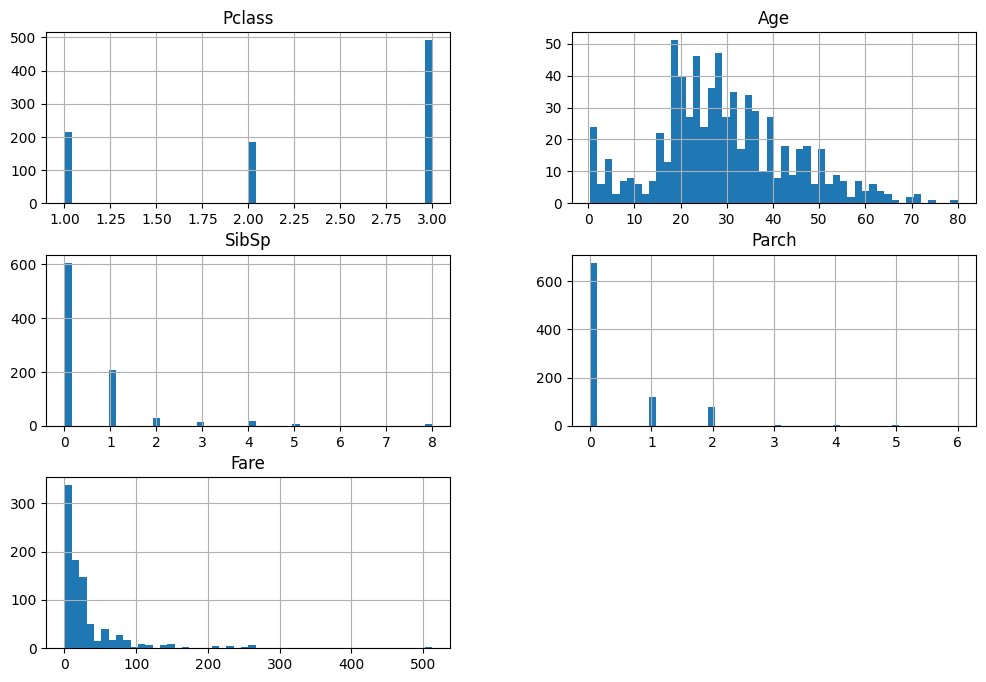

In [7]:
nec_num = nec_data.select_dtypes(include=[np.number])
nec_num.hist(bins=50, figsize=(12, 8))
plt.plot()

In [8]:
def safe_log(x):
    return np.log(x + 1e-10)
#thanks to ChatGPT 3.5 for this function

log_transformer = FunctionTransformer(func=safe_log, inverse_func=np.exp)
num_tail_pipeline = make_pipeline(SimpleImputer(strategy="median"), log_transformer, StandardScaler())
text_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
preprocess = ColumnTransformer([
    ("tail", num_tail_pipeline, ["Fare", "SibSp", "Parch"]),
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)

In [9]:
sgd_clf = Pipeline([("pre", preprocess), ("clf", SGDClassifier(loss='hinge', learning_rate="optimal", random_state=446))])
survived = np.array(survived).ravel()
sgd_clf.fit(nec_data, survived)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('tail',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function safe_log at 0x0000016BE7985120>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Fare', 'SibSp', 'Parch']),
                                                 ('text',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000016BE7975C60>)])),
                ('clf', SGDClassifier(random_state=446))])

In [10]:
print(sgd_clf.predict(nec_data[:10]))
print(survived[:10])

[0 1 1 1 0 0 0 0 1 1]
[0 1 1 1 0 0 0 0 1 1]


In [11]:
rmse = -cross_val_score(sgd_clf, nec_data, survived, scoring="neg_root_mean_squared_error", cv=10)
print(rmse)

[0.55079106 0.51929079 0.50835712 0.55079106 0.54049499 0.46204236
 0.43704832 0.50835712 0.52999894 0.46466019]


In [12]:
randarr = np.zeros(10)
for k in range(len(randarr)):
    randarr[k] = random.uniform(0.01, 0.05)
print(randarr)
param_distribs = {"clf__alpha": randarr}
rmd_search = RandomizedSearchCV(
    sgd_clf, param_distributions=param_distribs, n_iter=10, cv=3, scoring="neg_root_mean_squared_error", random_state=446
)

rmd_search.fit(nec_data, survived)

[0.02651103 0.01333201 0.02271867 0.02800825 0.03726924 0.02029152
 0.03102933 0.0440015  0.0378753  0.02857402]


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('tail',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(func=<function safe_log at 0x00...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000016BE7975C60>)])),
                                             ('clf',
                                              SGDClassifier(random_state=446))]),
                   param_distributions={'clf__alpha': array([0.02651103, 0.01333201, 0.02271867, 0.02800825, 0.03726924,
       0.02029152, 0.03102933, 0.0440015 , 0.0378753 , 0.02857402])},
                   random_state=446, scoring='neg_root_mean_squared_error')

In [13]:
final_model = rmd_search.best_estimator_
print(final_model.get_params)
rmse2 = -cross_val_score(final_model, nec_data, survived, scoring="neg_root_mean_squared_error", cv=10)
print(rmse2)

<bound method Pipeline.get_params of Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('tail',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function safe_log at 0x0000016BE7985120>,
                                                                                       inverse_func=<ufun...
                      

In [14]:
ids2 = np.array(test_set["PassengerId"].copy()).ravel()
test_pred = final_model.predict(test_set)
with open('sacreddeer_titanic_submission_1.csv', 'w', newline='') as f:
    # create the csv writer
    writer = csv.writer(f)
    writer.writerow(["PassengerId", "Survived"])
    for k in range(len(ids2)):
        # write a row to the csv file
        writer.writerow([ids2[k], test_pred[k]])